# 2. Analyse ML avec Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

### Données Framingham

https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset

Attributes/columns:

- male: 0 = Female; 1 = Male
- age: Age at exam time
- education: 1 = Some High School; 2 = High School or GED; 3 = Some College or Vocational School; 4 = college
- currentSmoker: 0 = nonsmoker; 1 = smoker
- cigsPerDay: number of cigarettes smoked per day (estimated average)
- BPMeds: 0 = Not on Blood Pressure medications; 1 = Is on Blood Pressure medications
- prevalentStroke
- prevalentHyp
- diabetes: 0 = No; 1 = Yes
- totChol in mg/dL
- sysBP in mmHg
- diaBP in mmHg
- BMI: Body Mass Index calculated as: Weight (kg) / Height(meter-squared)
- heartRate: Beats/Min (Ventricular)
- glucose in mg/dL

- TenYearCHD - Did the person get heart disease in the 10 years study period?
label; 0 = No for heart disease, 1 = Yes for heart disease;


In [183]:
import pandas as pd
url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(url)
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.00,0,0.00,0.00,0,0,0,195.00,106.00,70.00,26.97,80.00,77.00,0
1,0,46,2.00,0,0.00,0.00,0,0,0,250.00,121.00,81.00,28.73,95.00,76.00,0
2,1,48,1.00,1,20.00,0.00,0,0,0,245.00,127.50,80.00,25.34,75.00,70.00,0
3,0,61,3.00,1,30.00,0.00,0,1,0,225.00,150.00,95.00,28.58,65.00,103.00,1
4,0,46,3.00,1,23.00,0.00,0,0,0,285.00,130.00,84.00,23.10,85.00,85.00,0


## 1. Informations

In [185]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [186]:
import datetime
now = datetime.datetime.now()
print(now)

2020-03-16 12:53:29.093158


In [187]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.83


In [188]:
subscription_id = "70b8f39e-8863-49f7-b6ba-34a80799550c" 
resource_group = "MLOpsworkshopRG" 
workspace_name = "MLOpsWorkshop" 
workspace_region = "westeurope" 

# Expérience Azure ML
experiment_name = 'chd-prediction-notebook'

project_dir = './chd'
deployment_dir = './deploy'
model_name = 'chd-predictor-manual'
model_description = 'Model to predict coronory heart disease'

vm_name = "chd-manual"

In [190]:
import os
import logging

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.compute import ComputeTarget
from azureml.core.model import Model
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

## 2. Workspace Azure ML

In [191]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True) #Leverage existing

ws.write_config()
print('Workspace configuration succeeded')

Workspace configuration succeeded


In [192]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: MLOpsWorkshop
Azure region: westeurope
Resource group: MLOpsworkshopRG


In [196]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores:")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Compute Targets:
	 chdinf01 : AKS
	 chd-manual : AmlCompute
	 chd-temp-compute : AmlCompute
Datastores:
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets:


## 3. Expérimentation Azure ML

In [198]:
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

In [197]:
experiment = Experiment(ws, experiment_name)

In [199]:
# Infos
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
ws.get_details()

{'id': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/MLOpsWorkshopRG/providers/Microsoft.MachineLearningServices/workspaces/MLOpsWorkshop',
 'name': 'MLOpsWorkshop',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Enterprise',
 'workspaceid': '9576d631-3806-49d4-94ce-0966672d5e2b',
 'description': '',
 'friendlyName': '',
 'creationTime': '2020-03-12T11:03:20.1683295+00:00',
 'containerRegistry': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/MLOpsWorkshopRG/providers/Microsoft.ContainerRegistry/registries/mlopsworksho9f62d9a0',
 'keyVault': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourcegroups/mlopsworkshoprg/providers/microsoft.keyvault/vaults/mlopsworkshop7771179297',
 'applicationInsights': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourcegroups/mlopsworkshoprg/providers/microsoft.insights/components/mlopsworkshop9122234384',
 'identityPrincipalId': '9d2201

## 4. Azure ML Compute

In [200]:
# Liste des compute servers disponibles
from azureml.core.compute import ComputeTarget, AmlCompute
AmlCompute.supported_vmsizes(workspace = ws)

[{'name': 'Standard_D1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 51200},
 {'name': 'Standard_D2_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 7.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D3_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D4_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D11_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D12_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D13_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 56.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D14_v2',
  'vCPUs': 16,
  'gpus': 0,
  'memoryGB': 112.0,
  'maxResourceVolumeMB': 819200},
 {'name': 'Standard_DS1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 7168},
 {'name': 'Standar

In [201]:
# Provision AML managed compute 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

try:
    compute_target = ComputeTarget(workspace=ws, name=vm_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           min_nodes=1, max_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, vm_name, compute_config)
    # Show output
    compute_target.wait_for_completion(show_output=True)

Found existing compute target.


In [202]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores:")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Compute Targets:
	 chdinf01 : AKS
	 chd-manual : AmlCompute
	 chd-temp-compute : AmlCompute
Datastores:
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets:


In [203]:
experiment

Name,Workspace,Report Page,Docs Page
chd-prediction-notebook,MLOpsWorkshop,Link to Azure Machine Learning studio,Link to Documentation


## 5. Environnement

In [204]:
# Docker based environment avec scikit-learn
training_venv = Environment("training_venv")

training_venv.docker.enabled = True
training_venv.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'])

In [205]:
%%writefile $project_dir/train.py

import pandas as pd
import numpy as np
import pickle
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

dataset_url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(dataset_url)

smoke = (df['currentSmoker']==1)
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())

df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

features = df.iloc[:,:-1]
result = df.iloc[:,-1] # the last column is what we are about to forecast

# Train et Test
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

# RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train, y_train)

# Features selected
feat_labels = list(features.columns.values) # creating a list with features' names
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

# Feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking =")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# With only imporant features. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

# Calcul Accuracy
from sklearn import metrics
y_pred=clf.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)
print("Accuracy du modèle :", accuracy)

# Export modèle
os.makedirs('./outputs/model', exist_ok=True)

filename = './outputs/model/chd-rf-model'
pickle.dump(clf_important, open(filename, 'wb'))
print("model saved in ././outputs/model/chd-rf-model folder")
print("Saving model completed")

Overwriting ./chd/train.py


## 6. Run

In [206]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

src = ScriptRunConfig(source_directory=project_dir, script='train.py')

# Compute Target
src.run_config.target = compute_target.name

# Set environment
src.run_config.environment = training_venv
 
run = experiment.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
chd-prediction-notebook,chd-prediction-notebook_1584363431_53f9a22d,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


> Prévoir 2 minutes de temps de traitement

### Widget pour suivre l'avancement du run

In [207]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Pour suivre l'avancement du run

In [208]:
run.get_details()

{'runId': 'chd-prediction-notebook_1584363431_53f9a22d',
 'target': 'chd-manual',
 'status': 'Completed',
 'startTimeUtc': '2020-03-16T12:58:12.390278Z',
 'endTimeUtc': '2020-03-16T12:59:50.296026Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '0ae992f7-768f-4b4d-afa3-91bf509c58fa',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'chd-manual',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'training_venv',
   'version': 'Autosave_2020-03-12T11:20:58Z_8d96c929',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['conda-forge

In [209]:
# Statut du compute server
compute_target.list_nodes()

[{'nodeId': 'tvmps_1759bca279a5e09cc3828c3f386beb254261d5eff0553e7b93e2be0cab425153_d',
  'port': 50000,
  'publicIpAddress': '51.105.207.128',
  'privateIpAddress': '10.0.0.4',
  'nodeState': 'idle'}]

In [210]:
#get_status () gets the latest status of the AmlCompute target
compute_target.get_status().serialize()

{'currentNodeCount': 1,
 'targetNodeCount': 1,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 1,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2020-03-12T11:20:06.413000+00:00',
 'errors': None,
 'creationTime': '2020-03-12T11:18:12.415250+00:00',
 'modifiedTime': '2020-03-12T11:18:28.535667+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 1,
  'maxNodeCount': 1,
  'nodeIdleTimeBeforeScaleDown': ''},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_D12_V2'}

## 7. Référencement du modèle avec Azure ML

In [213]:
if run.get_status() == 'Completed':
    print("OK!")
    model_run = run.register_model(model_name=model_name,  
                               model_path="././outputs/model/chd-rf-model",
                               tags={"type": "classification", "description": model_description, "run_id": run.id})
    print("Version du modèle : ", model_run.version)
else:
    print("OK")
    Exception("Erreur")
    

OK!
Version du modèle :  5


### Liste des modèles référencés

In [214]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'Version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

chd-predictor-manual Version = 5
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 4
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 3
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 2
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584362608_e65973a4


AutoMLmodele Version = 3
	 Training context : Azure Auto ML
	 Accuracy : 0.850943396226415
	 AUC : 0.7015930531150851


AutoMLmodele Version = 2
	 Training context : Azure Auto ML
	 Accuracy : 0.850943396226415
	 AUC : 0.7015930531150851


chd-predictor Version = 4
	 type : classification
	 run_id : 74e98634-2032-4199-a6

In [215]:
experiment

Name,Workspace,Report Page,Docs Page
chd-prediction-notebook,MLOpsWorkshop,Link to Azure Machine Learning studio,Link to Documentation


## 7. AutoML avec Azure ML

https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/media/concept-automated-ml/automl-concept-diagram2.png">

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [216]:
import pandas as pd
dataset_url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(dataset_url)

In [217]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.00,0,0.00,0.00,0,0,0,195.00,106.00,70.00,26.97,80.00,77.00,0
1,0,46,2.00,0,0.00,0.00,0,0,0,250.00,121.00,81.00,28.73,95.00,76.00,0
2,1,48,1.00,1,20.00,0.00,0,0,0,245.00,127.50,80.00,25.34,75.00,70.00,0
3,0,61,3.00,1,30.00,0.00,0,1,0,225.00,150.00,95.00,28.58,65.00,103.00,1
4,0,46,3.00,1,23.00,0.00,0,0,0,285.00,130.00,84.00,23.10,85.00,85.00,0


In [218]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.00,4240.00,4135.00,4240.00,4211.00,4187.00,4240.00,4240.00,4240.00,4190.00,4240.00,4240.00,4221.00,4239.00,3852.00,4240.00
mean,0.43,49.58,1.98,0.49,9.01,0.03,0.01,0.31,0.03,236.70,132.35,82.90,25.80,75.88,81.96,0.15
std,0.50,8.57,1.02,0.50,11.92,0.17,0.08,0.46,0.16,44.59,22.03,11.91,4.08,12.03,23.95,0.36
min,0.00,32.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.54,44.00,40.00,0.00
25%,0.00,42.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,75.00,23.07,68.00,71.00,0.00
50%,0.00,49.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,234.00,128.00,82.00,25.40,75.00,78.00,0.00
75%,1.00,56.00,3.00,1.00,20.00,0.00,0.00,1.00,0.00,263.00,144.00,90.00,28.04,83.00,87.00,0.00
max,1.00,70.00,4.00,1.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


In [219]:
df.corr()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.00,-0.03,0.02,0.20,0.32,-0.05,-0.00,0.01,0.02,-0.07,-0.04,0.06,0.08,-0.12,0.01,0.09
age,-0.03,1.00,-0.17,-0.21,-0.19,0.12,0.06,0.31,0.10,0.26,0.39,0.21,0.14,-0.01,0.12,0.23
education,0.02,-0.17,1.00,0.02,0.01,-0.01,-0.04,-0.08,-0.04,-0.02,-0.13,-0.06,-0.14,-0.05,-0.04,-0.05
currentSmoker,0.20,-0.21,0.02,1.00,0.77,-0.05,-0.03,-0.10,-0.04,-0.05,-0.13,-0.11,-0.17,0.06,-0.06,0.02
cigsPerDay,0.32,-0.19,0.01,0.77,1.00,-0.05,-0.03,-0.07,-0.04,-0.03,-0.09,-0.06,-0.09,0.08,-0.06,0.06
BPMeds,-0.05,0.12,-0.01,-0.05,-0.05,1.00,0.12,0.26,0.05,0.08,0.25,0.19,0.10,0.02,0.05,0.09
prevalentStroke,-0.00,0.06,-0.04,-0.03,-0.03,0.12,1.00,0.07,0.01,0.00,0.06,0.05,0.03,-0.02,0.02,0.06
prevalentHyp,0.01,0.31,-0.08,-0.10,-0.07,0.26,0.07,1.00,0.08,0.16,0.70,0.62,0.30,0.15,0.09,0.18
diabetes,0.02,0.10,-0.04,-0.04,-0.04,0.05,0.01,0.08,1.00,0.04,0.11,0.05,0.09,0.05,0.62,0.10
totChol,-0.07,0.26,-0.02,-0.05,-0.03,0.08,0.00,0.16,0.04,1.00,0.21,0.16,0.12,0.09,0.05,0.08


In [220]:
df.shape

(4240, 16)

## Paramétrage AutoML

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [221]:
# Variable à modéliser
targetvariable ="TenYearCHD"

In [222]:
experiment = Experiment(ws, "AutoML-notebook-SDK")

### Distribution variable Cible

<Figure size 720x360 with 0 Axes>

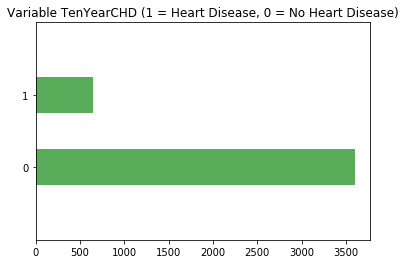

<Figure size 720x360 with 0 Axes>

In [224]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
fig, ax = plt.subplots()
df.TenYearCHD.value_counts().plot(kind='barh', color="green", alpha=.65)
ax.set_ylim(-1, len(df.TenYearCHD.value_counts())) 
plt.title("Variable TenYearCHD (1 = Heart Disease, 0 = No Heart Disease)")
plt.figure(figsize=(10,5))


In [225]:
automl_settings = {
    "enable_early_stopping": True,              # Critère arrêt
    "iterations" : 15,                          # Itérations max
    "iteration_timeout_minutes" : 5,            # Temps max par itération
    "experiment_timeout_minutes" : 10,          # Temps max pour le process AutoML
    "n_cross_validations": 5,                   # Validation croisée
    "primary_metric": 'accuracy',               # Choix de la métrique
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification', #Type de programme autoML
                             debug_log = 'automl.log', #Log
                             preprocess=True, #dataprep
                             training_data = df, #Training dataset
                             label_column_name = targetvariable, #Nom variable cible
                             **automl_settings
                            )

In [226]:
automl_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_8594dbbf-ea76-4665-b4b1-74146e47aa31

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

TYPE:         Missing values imputation
STATUS:       FIXED
DESCRIPTION:  The training data had the following missing values which were resolved. Please review your data source for data quality issues and possibly filter out the rows with these missing values. If the missing values are exp

In [236]:
automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-notebook-SDK,AutoML_8594dbbf-ea76-4665-b4b1-74146e47aa31,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [237]:
# Widget
from azureml.widgets import RunDetails
RunDetails(automl_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Liste des itérations AutoML par métrique

In [238]:
children = list(automl_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AUC_macro,0.65,0.69,0.70,0.66,0.70,0.68,0.70,0.67,0.67,0.67,0.70,0.69,0.68,0.70,0.70
AUC_micro,0.88,0.90,0.72,0.67,0.90,0.73,0.90,0.69,0.67,0.68,0.90,0.70,0.71,0.90,0.90
AUC_weighted,0.65,0.69,0.70,0.66,0.70,0.68,0.70,0.67,0.67,0.67,0.70,0.69,0.68,0.70,0.70
accuracy,0.84,0.85,0.66,0.63,0.85,0.66,0.85,0.66,0.65,0.65,0.85,0.63,0.63,0.85,0.85
average_precision_score_macro,0.59,0.61,0.62,0.58,0.62,0.61,0.61,0.60,0.59,0.59,0.61,0.61,0.60,0.62,0.62
average_precision_score_micro,0.87,0.88,0.71,0.64,0.89,0.73,0.89,0.69,0.66,0.68,0.89,0.68,0.68,0.89,0.89
average_precision_score_weighted,0.81,0.82,0.83,0.81,0.83,0.82,0.83,0.82,0.82,0.82,0.83,0.82,0.82,0.83,0.83
balanced_accuracy,0.53,0.52,0.65,0.63,0.51,0.63,0.52,0.62,0.62,0.62,0.50,0.64,0.62,0.52,0.51
f1_score_macro,0.53,0.51,0.57,0.54,0.48,0.56,0.49,0.55,0.55,0.55,0.46,0.55,0.54,0.51,0.48
f1_score_micro,0.84,0.85,0.66,0.63,0.85,0.66,0.85,0.66,0.65,0.65,0.85,0.63,0.63,0.85,0.85


### Obtention du meilleur modèle AutoML

In [239]:
best_run, fitted_model = automl_run.get_output()
print(best_run)
print(fitted_model)
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: AutoML-notebook-SDK,
Id: AutoML_8594dbbf-ea76-4665-b4b1-74146e47aa31_13,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...          flatten_transform=None,
               weights=[0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1]))])
AUC_macro 0.7034307612380879
balanced_accuracy 0.5236040869698717
accuracy 0.8523584905660379
AUC_micro 0.9008721965112141
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_8594dbbf-ea76-4665-b4b1-74146e47aa31_13/accuracy_table
norm_macro_recall 0.04720817393974328
recall_score_weighted 0.8523584905660379
precision_score_weighted 0.8307491011393262
average_precision_score_weighted 0.8329345142104204
log_loss 0.42731726068448034
f1_score

In [240]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...          flatten_transform=None,
               weights=[0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1]))])>

In [241]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('1', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('sgdclassifierwrapper', SGDClassifierWrapper(alpha=0.8164183673469387, class_weight=None, eta0=0.01,
             fit_intercept=True, l1_ratio=0.36734693877551017,
             learning_rate='constant', loss=...obs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]))],
                 flatten_transform=None,
                 weights=[0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1]))]

### Référencement du meilleur modèle AutoML

In [242]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='AutoMLmodele',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'Accuracy': best_run_metrics['accuracy'], 'AUC': best_run_metrics['AUC_weighted']})

Model(workspace=Workspace.create(name='MLOpsWorkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='MLOpsworkshopRG'), name=AutoMLmodele, id=AutoMLmodele:5, version=5, tags={'Training context': 'Azure Auto ML'}, properties={'Accuracy': '0.8523584905660379', 'AUC': '0.7034307612380879'})

### Liste des modèles référencés

In [243]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'Version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

AutoMLmodele Version = 5
	 Training context : Azure Auto ML
	 Accuracy : 0.8523584905660379
	 AUC : 0.7034307612380879


AutoMLmodele Version = 4
	 Training context : Azure Auto ML
	 Accuracy : 0.8523584905660379
	 AUC : 0.7034307612380879


chd-predictor-manual Version = 5
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 4
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 3
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-notebook_1584363431_53f9a22d


chd-predictor-manual Version = 2
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584362608_e65973a4


AutoMLmodele Version = 3
	 Training context : Azure Auto ML
	 Accuracy : 0.85094

### Accès expérimentation Azure ML

In [244]:
experiment

Name,Workspace,Report Page,Docs Page
AutoML-notebook-SDK,MLOpsWorkshop,Link to Azure Machine Learning studio,Link to Documentation


> Fin